### 1. Importing the necessary libraries.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    f1_score,
)
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    true_negative_rate,
)

### 2. Importing the dataset.

Utrecht Fairness Recruitment dataset ([see here](https://www.kaggle.com/datasets/ictinstitute/utrecht-fairness-recruitment-dataset)) is a synthetic dataset created to help educators and researchers understand fairness definitions. The dataset contains multiple sensitive features: age, gender, and lives-near-by. These can be combined to define many different sensitive groups.

In [2]:
df = pd.read_csv(
    "recruitmentdataset-2022-1.3.csv"
)

### 3. Feature engineering and datapreprocessing.

We encode all our categorical variables, and define the features and the target of our model. Finally, we also split our features and targets between a traning and a test dataset.

In [3]:
# Encoding categorical variables
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded = encoder.fit_transform(
    df[
        [
            "gender",
            "nationality",
            "sport",
            "debate_club",
            "prog_exp",
            "int_exp",
            "ent_exp",
            "exact_study",
            "highest_degree",
            "company",
        ]
    ]
)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())

# Concatenating encoded variables with original dataframe
df = pd.concat([df, encoded_df], axis=1)

# More interested in having variable gender female
df["gender_female"] = ((df["gender_male"] == 0) & (df["gender_other"] == 0)).astype(int)
df.drop(["gender_male"], axis=1, inplace=True)

# Same for belgian nationality
df["nationality_Belgian"] = (
    (df["nationality_Dutch"] == 0) & (df["nationality_German"] == 0)
).astype(int)
df.drop(["nationality_Dutch"], axis=1, inplace=True)

# Selecting relevant features to feed the model
X = df[
    [
        "age",
        "grade",
        "languages",
        "gender_female",
        "gender_other",
        "nationality_Belgian",
        "nationality_German",
        "sport_Cricket",
        "sport_Football",
        "sport_Golf",
        "sport_Rugby",
        "sport_Running",
        "sport_Swimming",
        "sport_Tennis",
        "debate_club_True",
        "prog_exp_True",
        "int_exp_True",
        "ent_exp_True",
        "exact_study_True",
        "highest_degree_master",
        "highest_degree_phd",
        "company_B",
        "company_C",
        "company_D",
    ]
]

# Selecting the target
y = df["decision"]

# Splitting both X and y into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### 4. Fitting our model.

In this section we fit our model. Even though accuracy is not the main scope of the project, we perform a quick grid search to find suitable hyperparameters.

In [4]:
param_grid = {
    "learning_rate": [0.01, 0.05],
    "max_iter": [100, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [20, 30],
    "l2_regularization": [1.0],
}

grid = GridSearchCV(
    HistGradientBoostingClassifier(class_weight="balanced", random_state=42),
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


### 5. Model evaluation.

In [5]:
y_probs = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

y_pred = (y_probs >= best_threshold).astype(int)

print(f"Best threshold: {best_threshold:.3f}\n")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

Best threshold: 0.490

Confusion Matrix:
 [[698 122]
 [ 32 348]]

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.85      0.90       820
        True       0.74      0.92      0.82       380

    accuracy                           0.87      1200
   macro avg       0.85      0.88      0.86      1200
weighted avg       0.89      0.87      0.87      1200

Accuracy: 0.8717
F1 Score (macro): 0.8597


Plotting the confusion matrix.

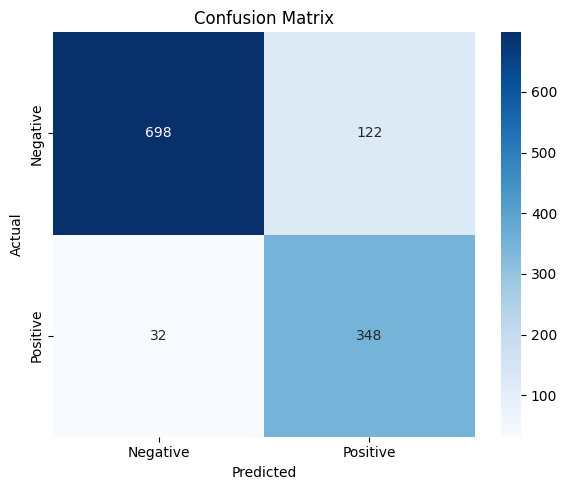

In [6]:
conf = confusion_matrix(y_test, y_pred)

labels = ["Negative", "Positive"]

plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(
    conf, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

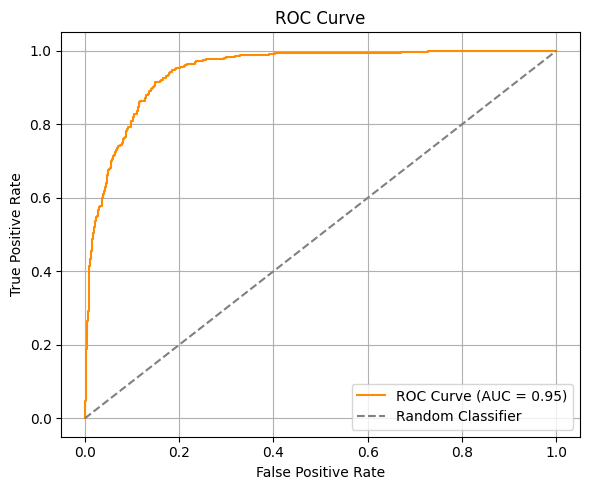

In [7]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Exploring the bias in our model.

We plot some basic metrics to explore the bias in the case of two sensitive features: gender and age.

In [8]:
X_test["under_30"] = (X_test["age"] < 30).astype(int)
X_test["nationality_Dutch"] = (
    (X_test["nationality_German"] == 0) & (X_test["nationality_Belgian"] == 0)
).astype(int)

fair_metrics = pd.DataFrame()
for sen_var in [
    "under_30",
    "gender_female",
    "gender_other",
    "nationality_German",
    "nationality_Belgian",
    "nationality_Dutch",
]:

    print(f"\n==========Bias assesment for variable {sen_var}============")
    mf = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
            "TPR": true_positive_rate,
            "FPR": false_positive_rate,
            "FNR": false_negative_rate,
            "TNR": true_negative_rate,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test[sen_var],
    )

    print(mf.by_group)

    fair_metrics = pd.concat(
        [fair_metrics, mf.by_group.reset_index(drop=False)], axis=0
    )

fair_metrics.to_excel("fair_metrics.xlsx")


==========Bias assesment for variable under_30============
          accuracy  selection_rate       TPR       FPR       FNR       TNR
under_30                                                                  
0          0.93125        0.456250  1.000000  0.112245  0.000000  0.887755
1          0.86250        0.381731  0.899371  0.153740  0.100629  0.846260

==========Bias assesment for variable gender_female============
               accuracy  selection_rate       TPR       FPR       FNR  \
gender_female                                                           
0              0.863636        0.443939  0.939394  0.177156  0.060606   
1              0.881481        0.327778  0.879195  0.117647  0.120805   

                    TNR  
gender_female            
0              0.822844  
1              0.882353  

==========Bias assesment for variable gender_other============
              accuracy  selection_rate       TPR       FPR       FNR       TNR
gender_other                       

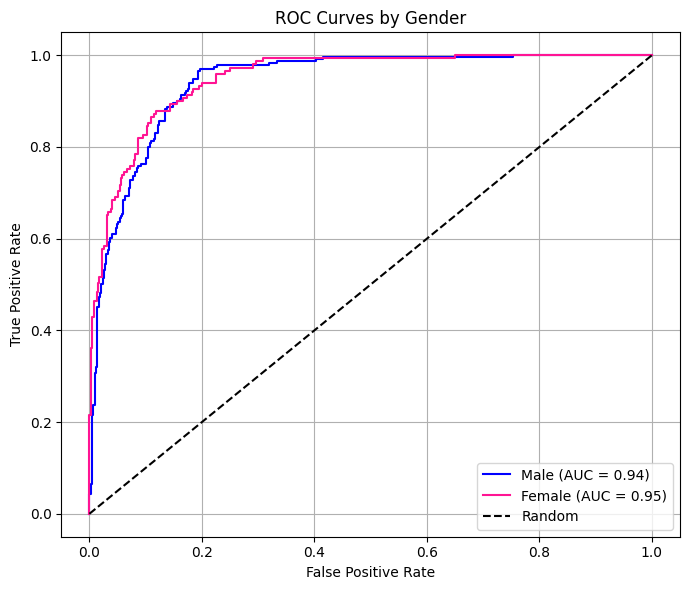

In [9]:
# Assuming you have a column 'is_female' in your test set
male_mask = X_test["gender_female"] == 0
female_mask = X_test["gender_female"] == 1

# Split true labels and predicted probs by gender
y_true_male = y_test[male_mask]
y_true_female = y_test[female_mask]

y_prob_male = y_probs[male_mask]
y_prob_female = y_probs[female_mask]

# Compute ROC curves and AUC
fpr_male, tpr_male, _ = roc_curve(y_true_male, y_prob_male)
fpr_female, tpr_female, _ = roc_curve(y_true_female, y_prob_female)

auc_male = roc_auc_score(y_true_male, y_prob_male)
auc_female = roc_auc_score(y_true_female, y_prob_female)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr_male, tpr_male, label=f"Male (AUC = {auc_male:.2f})", color="blue")
plt.plot(
    fpr_female, tpr_female, label=f"Female (AUC = {auc_female:.2f})", color="deeppink"
)
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Gender")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()